In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
import datasets
import transformers
import evaluate
from einops import rearrange
import re
import random
import functools
import submitit
import torch
import numpy as np
import matplotlib.pyplot as plt

from cupbearer import data, tasks, detectors, models, utils
from dataclasses import dataclass

/nas/ucb/erik/miniconda3/envs/abstractions/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/nas/ucb/erik/miniconda3/envs/abstractions/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
imdb = datasets.load_dataset("imdb")
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "distilbert/distilbert-base-uncased"
)

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "logs/imdb/train_backdoor/checkpoint-1563",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)


# Using a subset of the data just for faster iteration:
train_data = data.HuggingfaceDataset(imdb["train"].shuffle().select(range(10000)))
test_data = data.HuggingfaceDataset(imdb["test"].shuffle().select(range(1000)))

# Set up the cupbearer task:
cup_model = models.HuggingfaceLM(tokenizer=tokenizer, model=model)
backdoor = data.SentenceBackdoor(tokenizer=tokenizer)
task = tasks.backdoor_detection(
    model=cup_model, train_data=train_data, test_data=test_data, backdoor=backdoor
)


activation_names = ["hf_model.pre_classifier.input"]
cache = detectors.FeatureCache(device="cuda")
detector = detectors.MahalanobisDetector(activation_names=activation_names, cache=cache)

2024-07-18 15:02:08.167 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data
2024-07-18 15:02:08.618 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
hf_model.pre_classifier.input: torch.Size([768])
100%|██████████| 313/313 [00:42<00:00,  7.44it/s]


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
2024-07-18 15:02:55.513 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (all): 0.9559
2024-07-18 15:02:55.513 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (all): 0.9253


(defaultdict(dict, {'all': {'AUC_ROC': 0.955944, 'AP': 0.925267628120407}}),
 {'all': <Figure size 640x480 with 1 Axes>})

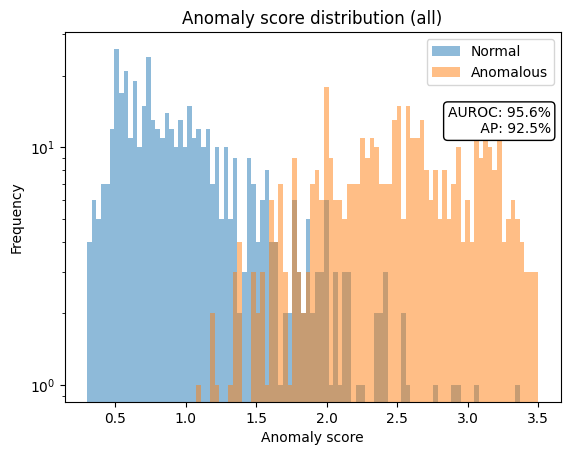

In [ ]:
detector.train(task)
detector.eval(task, pbar=True, batch_size=64)